# k-Nearest Neighbors

In [37]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder
import numpy as np
import pandas as pd
import hashlib

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score  , f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# constants
username = "shubham.goel"
num_of_students = 10000
seed = int ( hashlib.sha256(username.encode()).hexdigest(),16)%(2**32)
print(seed)

3029262140


In [39]:
# StudentDataset class

class STUDENT_DATASET:
    def __init__(self , num_students : int , seed : int):
        ''' Generates the full dataset during initialization using the specified number of students and seed.'''
        self.num_students = num_students
        self.rng = np.random.default_rng(seed)
        self.df = self.assemble_dataframes()
        

    def get_full_dataframe(self):
        return self.df
        

    def generate_gender(self):
        genders = ["Male" , "Female" ,"Other"]
        probs =  [0.65 ,0.33,0.02]
        return self.rng.choice(genders , size =self.num_students ,p =  probs).tolist()
        

    def generate_major(self):
        majors= ["B.Tech","MS","PHD"]
        probs =[0.70,0.20,0.10]
        return self.rng.choice(majors , self.num_students , p  = probs)
        

    def generate_program(self , majors:list[str])->list[str]:
        programs = []
        for m in majors:
            if m == "B.Tech":
                p = ["CSE", "ECE", "CHD", "CND"]
                probs = [0.40, 0.40, 0.10, 0.10]
            elif m == "MS":
                p = ["CSE", "ECE", "CHD", "CND"]
                probs = [0.30, 0.30, 0.20, 0.20]
            elif m == "PHD":
                 p = ["CSE", "ECE", "CHD", "CND"]
                 probs = [0.25, 0.25, 0.25, 0.25]

            programs.append(self.rng.choice(p , p  = probs))
        return programs

    def generate_gpa(self ,majors : list[str])->list[float]:
        gpas = []
        for m in majors:
            if m == "B.Tech":
                g = self.rng.normal(7.0,1.0)
            elif m == "PHD":
                g = self.rng.normal(8.0,0.7)

            elif m == "MS":
                g = self.rng.normal(8.3,0.5)

            g = np.clip(g,4.0,10.0)
            gpas.append(round(float(g),2))
        return gpas

    def assemble_dataframes(self):
        genders = self.generate_gender()
        majors = self.generate_major()
        programs = self.generate_program(majors)
        gpas = self.generate_gpa(majors)

        df   = pd.DataFrame({
            "Gender": genders,
            "Major": majors,
            "Program": programs,
            "GPA": gpas
        })
        return df


In [40]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.params = None
        self.fitted = False

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.

        Parameters:
        df : The dataframe containing features to be transformed.
        params : A dictionary mapping feature name to transformation type,
        e.g., {"GPA": "standard", "Major": "ordinal", "Program": "onehot"}.
        """
        self.params = params
        for col, t_type in params.items():
            if t_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[col]])
                self.transformers[col] = scaler
            elif t_type == "onehot":
                enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
                enc.fit(df[[col]])
                self.transformers[col] = enc
            elif t_type == "ordinal":
                enc = OrdinalEncoder()
                enc.fit(df[[col]])
                self.transformers[col] = enc
            else:
                raise ValueError(f"Unknown transformation type {t_type}")
        self.fitted = True

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """
        Applies the fitted transformers to the corresponding features and returns a NumPy array.
        """
        if not self.fitted:
            raise RuntimeError("Transformer not fitted yet.")

        transformed_features = []
        for col, t_type in self.params.items():
            transformer = self.transformers[col]
            arr = transformer.transform(df[[col]])
            transformed_features.append(arr)
        return np.hstack(transformed_features)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """
        Fits and transforms all features in one step using the given transformation parameters.
        """
        self.fit(df, params)
        return self.transform(df)

In [41]:
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        """
        Initializes the predictor with the full student dataset.
        Use the username for plots.
        """
        self.df = student_df
        self.username = username
        self.transformer = PerFeatureTransformer()
        self.train_df = None
        self.val_df = None
        self.test_df = None
        self.params = None

    def train_val_test_split(self, test_size: float = 0.2, val_size: float = 0.2,
                             seed: int = 42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Splits the dataset into train, validation, and test sets with stratification on Gender.
        """
        train_df, test_df = train_test_split(
            self.df, test_size=test_size, random_state=seed, stratify=self.df["Gender"]
        )
        train_df, val_df = train_test_split(
            train_df, test_size=val_size, random_state=seed, stratify=train_df["Gender"]
        )
        self.train_df, self.val_df, self.test_df = train_df, val_df, test_df
        return train_df, val_df, test_df

    def get_feature_matrix_and_labels(self, df: pd.DataFrame, features: list[str]) -> tuple[np.ndarray, np.ndarray]:
        """
        Extract selected features and gender labels from the DataFrame.
        Applies encoding to categorical variables and normalizes numeric features.
        Do not fit encoders or scalers on test data. Only transform using previously fitted ones.
        """
        X = self.transformer.transform(df[features])
        y = df["Gender"].values
        return X, y

    def get_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean") -> list[float]:
        """
        Calculates accuracy scores for various k values on the validation set.
        """
        features = list(self.params.keys())
        X_train, y_train = self.get_feature_matrix_and_labels(self.train_df, features)
        X_val, y_val = self.get_feature_matrix_and_labels(self.val_df, features)

        accuracies = []
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracies.append(accuracy_score(y_val, y_pred))
        return accuracies

    def plot_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean") -> None:
        """
        Plots accuracy scores against k values on the validation set.
        """
        accuracies = self.get_knn_accuracy_vs_k(k_values, distance)
        plt.figure(figsize=(8, 5))
        plt.plot(k_values, accuracies, marker="o")
        plt.title(f"KNN Accuracy vs k ({distance}) - {self.username}")
        plt.xlabel("k")
        plt.ylabel("Validation Accuracy")
        plt.show()

    def get_knn_f1_heatmap(self, k_values: list[int], distances: list[str]) -> pd.DataFrame:
        """
        Returns a dataframe with the F1-score for each combination on the validation set.
        """
        features = list(self.params.keys())
        X_train, y_train = self.get_feature_matrix_and_labels(self.train_df, features)
        X_val, y_val = self.get_feature_matrix_and_labels(self.val_df, features)

        results = {}
        for dist in distances:
            f1s = []
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_val)
                f1s.append(f1_score(y_val, y_pred, average="weighted"))
            results[dist] = f1s

        return pd.DataFrame(results, index=k_values)

    def plot_knn_f1_heatmap(self, f1_scores_df: pd.DataFrame) -> None:
        """
        Plots a heatmap of F1 scores for different k and distance values.
        """
        plt.figure(figsize=(10, 6))
        sns.heatmap(f1_scores_df, annot=True, fmt=".2f", cmap="Blues")
        plt.title(f"KNN F1-Score Heatmap - {self.username}")
        plt.xlabel("Distance Metric")
        plt.ylabel("k")
        plt.show()

    def get_knn_f1_single_feature_table(self, k_values: list[int], features: list[str],
                                    distance: str = "euclidean") -> pd.DataFrame:
        """
        Creates a table of F1 scores on the test set using only a single feature for prediction.
        Rows: k values, Columns: features.
        """
        results = []
        for feature in features:
            # Fit transformer only on training set with one feature
            transformer = PerFeatureTransformer()
            transformer.fit(self.train_df[[feature]], {feature: self.params[feature]})
            X_train = transformer.transform(self.train_df[[feature]])
            y_train = self.train_df["Gender"].values
            X_test = transformer.transform(self.test_df[[feature]])
            y_test = self.test_df["Gender"].values

            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)
                f1 = f1_score(y_test, y_pred, average="weighted")
                results.append({"Feature": feature, "k": k, "F1-score": f1})

        df = pd.DataFrame(results)

        # ✅ Fix: use pivot_table instead of pivot
        f1_table = df.pivot_table(
            index="k",
            columns="Feature",
            values="F1-score",
            aggfunc="mean"   # In case duplicates exist
        )

        return f1_table



In [42]:
dataset = STUDENT_DATASET(num_students=num_of_students,seed=seed)
df = dataset.get_full_dataframe()
print(df.head())

   Gender   Major Program   GPA
0    Male      MS     CSE  8.37
1  Female  B.Tech     CHD  6.76
2    Male  B.Tech     ECE  8.86
3    Male  B.Tech     ECE  7.98
4    Male      MS     ECE  8.58


In [43]:
params ={
    "GPA":"standard",
    "Major":"onehot",
    "Program":"onehot"
}

In [44]:
predictor = KNNGenderPredictor(student_df=df ,username=username)
predictor.params = params

Train/val/test split the dataset and apply the data transforms. [4]

In [45]:
train_df   , val_df , test_df = predictor.train_val_test_split(test_size=0.2 , val_size=0.2 , seed=seed)
print(train_df.shape, val_df.shape, test_df.shape)

(6400, 4) (1600, 4) (2000, 4)


In [46]:
predictor.transformer.fit(train_df[list(params.keys())],params)
# print(predictor.get_feature_matrix_and_labels(train_df , ["Major","Program","GPA"])[0])

What value of k (odd values from 1 to 21) gave the highest accuracy on the validation
set with Euclidean distance metric? Justify with a plot. [2]

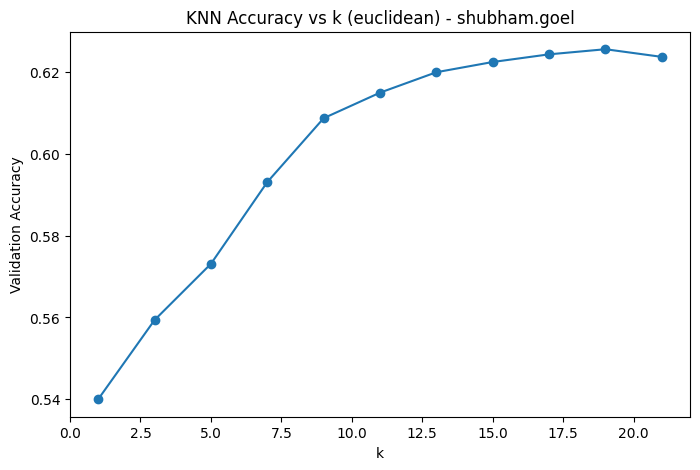

In [47]:
k_values = [1,3,5,7,9,11,13,15,17,19,21]
predictor.plot_knn_accuracy_vs_k(k_values , distance="euclidean")

Repeat the above for distance metrics like Manhattan and Cosine Similarity. [4]

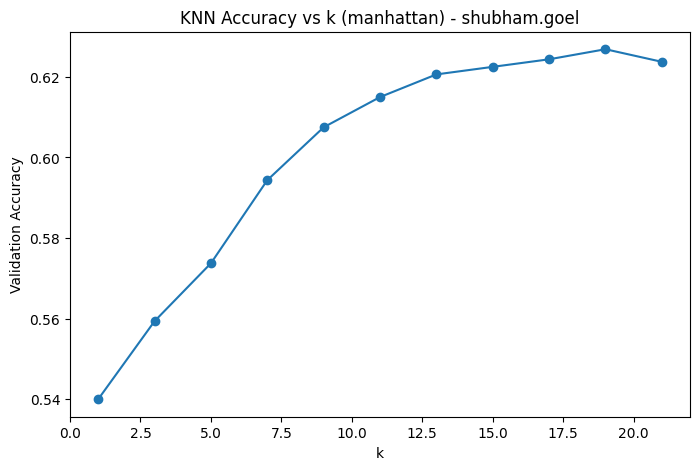

In [48]:
predictor.plot_knn_accuracy_vs_k(k_values , distance="manhattan")

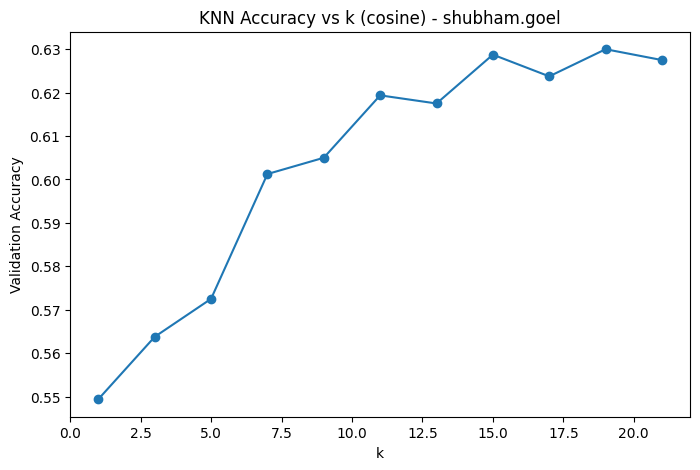

In [49]:
predictor.plot_knn_accuracy_vs_k(k_values , distance="cosine")

Report the validation F-1 score vs k for all the three distance metrics. [4]

In [50]:
f1_df = predictor.get_knn_f1_heatmap(k_values , ["euclidean","manhattan","cosine"])
print(f1_df)

    euclidean  manhattan    cosine
1    0.539792   0.539792  0.549576
3    0.542577   0.542577  0.551078
5    0.545243   0.546082  0.545085
7    0.553102   0.554897  0.556966
9    0.551420   0.551240  0.551394
11   0.544813   0.544813  0.557016
13   0.539636   0.542875  0.545113
15   0.533640   0.534421  0.543716
17   0.534117   0.533173  0.540633
19   0.537365   0.537046  0.537460
21   0.525366   0.524507  0.528358


Plot a heatmap: k × distance function vs F-1 score. [4]

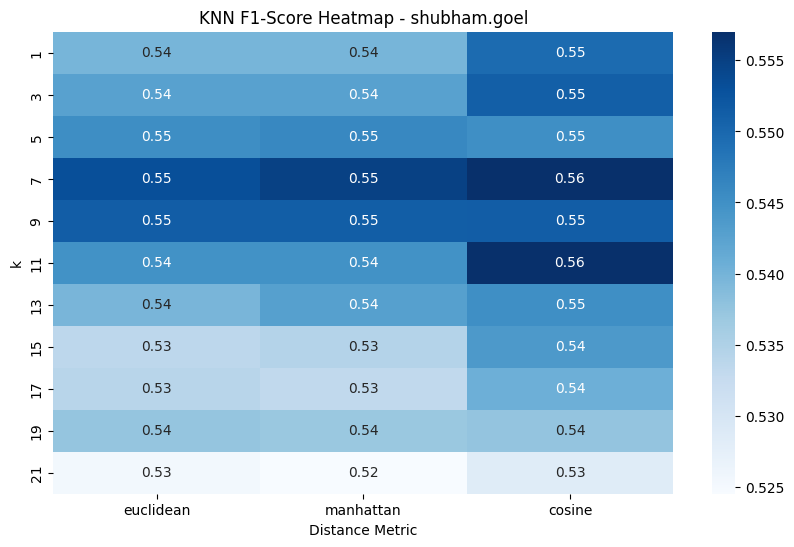

In [51]:
predictor.plot_knn_f1_heatmap(f1_df)

Which distance metric performs better? Why might that be? [2]

> cosine similarity performed better

 The main reason for this difference in performance is the fact that we are using one hot encoding and ordinal encoding. This will affect euclidian and manhattan distance as they are sensitive to the magnitude of the features. Cosine distance, on the other hand, is not concerned with magnitude but with the angle between two data points.

Instead of using all student features, an alternative is to use a single feature for pre-
diction. Create an F-1 score table where rows are various values of k, columns are the
single features used. Report values for test set for all the distance metrics. [6]

In [52]:
predictor.get_knn_f1_single_feature_table(k_values , params.keys(),"euclidean")

Feature,GPA,Major,Program
k,,,
1,0.542658,0.521001,0.521001
3,0.542903,0.521001,0.521001
5,0.540405,0.559246,0.521001
7,0.535515,0.559246,0.521001
9,0.533544,0.559246,0.521001
11,0.542221,0.559246,0.521001
13,0.544918,0.559246,0.521001
15,0.537228,0.559246,0.521001
17,0.536302,0.521001,0.521001


In [53]:
predictor.get_knn_f1_single_feature_table(k_values , params.keys(),"manhattan")

Feature,GPA,Major,Program
k,,,
1,0.542658,0.521001,0.521001
3,0.542903,0.521001,0.521001
5,0.540405,0.559246,0.521001
7,0.535515,0.559246,0.521001
9,0.533544,0.559246,0.521001
11,0.542221,0.559246,0.521001
13,0.544918,0.559246,0.521001
15,0.537228,0.559246,0.521001
17,0.536302,0.521001,0.521001


In [54]:
predictor.get_knn_f1_single_feature_table(k_values , params.keys(),"cosine")

Feature,GPA,Major,Program
k,,,
1,0.521001,0.521001,0.521001
3,0.521001,0.559246,0.521001
5,0.521001,0.559246,0.521001
7,0.521001,0.559246,0.521001
9,0.521001,0.559246,0.521001
11,0.521001,0.559246,0.521001
13,0.521001,0.559246,0.521001
15,0.521001,0.559246,0.521001
17,0.521001,0.559246,0.521001


Which single feature performed the best? How does it compare with the result using
all the features? Why? [4]

The F1-score tables for Euclidean, Manhattan, and Cosine distances show that Major is the single best predictive feature, achieving the highest test F1-score (≈0.559 with Euclidean/Manhattan).

GPA performs moderately well (~0.545), while Program is the weakest predictor (~0.521).

Using all features together outperforms any single feature, since combining GPA, Major, and Program captures complementary information about gender.

Major alone works best among single features because it has the strongest correlation with Gender (certain majors are gender-skewed), whereas GPA and Program have weaker associations.